#Golden Cross / Death Cross S&P 500 index (^GSPC)

In [1]:
%matplotlib inline

Use future imports for python 3.0 forward compatibility

In [2]:
from __future__ import print_function
from __future__ import unicode_literals
from __future__ import division
from __future__ import absolute_import

Other imports

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from talib.abstract import *
import pinkfish as pf

# format price data
pd.options.display.float_format = '{:0.2f}'.format

# Double the DPI, so we are making 2x plots:
matplotlib.rcParams['savefig.dpi'] = 2 * matplotlib.rcParams['savefig.dpi']

Some global data

In [4]:
symbol = '^GSPC'
#symbol = 'SPY'
#symbol = 'DIA'
#symbol = 'QQQ'
#symbol = 'IWM'
#symbol = 'TLT'
#symbol = 'GLD'
#symbol = 'AAPL'
#symbol = 'BBRY'
capital = 10000
start = datetime.datetime(2000, 1, 1)
end = datetime.datetime(2015, 5, 1)

Fetch symbol data from internet

In [5]:
ts = pf.fetch_timeseries(symbol)

In [6]:
ts.head()

,open,high,low,close,volume,adj_close
date,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,16.66
1950-01-04,16.85,16.85,16.85,16.85,1890000,16.85
1950-01-05,16.93,16.93,16.93,16.93,2550000,16.93
1950-01-06,16.98,16.98,16.98,16.98,2010000,16.98
1950-01-09,17.08,17.08,17.08,17.08,2520000,17.08


Select timeseries between start and end. Back adjust prices relative to adj_close for dividends and splits.

In [7]:
ts = pf.select_tradeperiod(ts, start, end, use_adj=True)

In [8]:
ts.head()

,open,high,low,close,volume,adj_close
date,,,,,,
1999-01-04,1229.23,1248.81,1219.10,1228.10,877000000,1228.10
1999-01-05,1228.10,1246.11,1228.10,1244.78,775000000,1244.78
1999-01-06,1244.78,1272.50,1244.78,1272.34,986900000,1272.34
1999-01-07,1272.34,1272.34,1257.68,1269.73,863000000,1269.73
1999-01-08,1269.73,1278.24,1261.82,1275.09,937800000,1275.09


Add technical indicator: 50 day ma, and 200 day ma

In [9]:
sma50 = SMA(ts, timeperiod=50)
ts['sma50'] = sma50

sma200 = SMA(ts, timeperiod=200)
ts['sma200'] = sma200

In [10]:
ts.tail()

,open,high,low,close,volume,adj_close,sma50,sma200
date,,,,,,,,
2015-04-27,2119.29,2125.92,2107.04,2108.92,3438750000,2108.92,2090.08,2024.07
2015-04-28,2108.35,2116.04,2094.89,2114.76,3546270000,2114.76,2090.43,2024.81
2015-04-29,2112.49,2113.65,2097.41,2106.85,4074970000,2106.85,2090.56,2025.45
2015-04-30,2105.52,2105.52,2077.59,2085.51,4509680000,2085.51,2090.28,2026.02
2015-05-01,2087.38,2108.41,2087.38,2108.29,3379390000,2108.29,2090.49,2026.65


Plot closing price along with moving averages

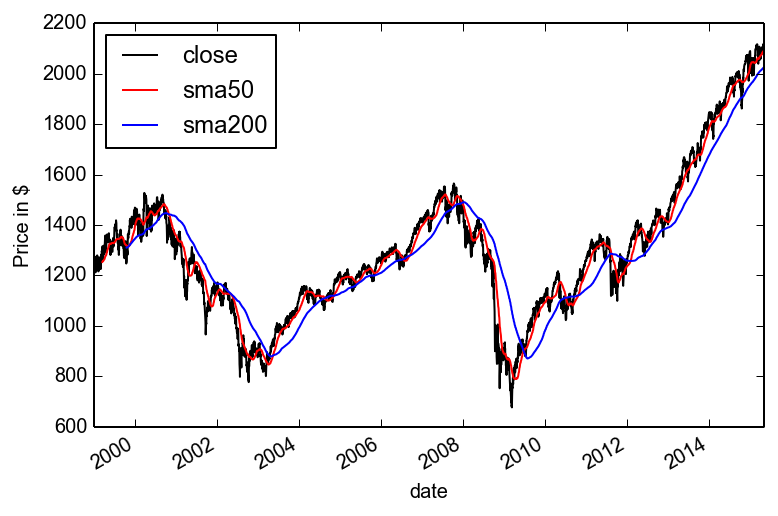

In [11]:
fig = plt.figure()
axes = fig.add_subplot(111,  ylabel='Price in $')

ts['close'].plot(ax=axes, label='close', color='k')
ts['sma50'].plot(ax=axes, label='sma50', color='r')
ts['sma200'].plot(ax=axes, label='sma200', color='b')
plt.legend(loc='best')

Create Trade Log (tlog); Create Daily Balance (dbal)

In [12]:
tlog = pf.TradeLog()
dbal = pf.DailyBal()

Algo: Buy when 50 day ma crosses above 200 day ma.  Sell when 50 day ma crosses below 200 day ma. 

In [13]:
cash = capital
shares = 0
start_flag = True

import time
t0 = time.time()


for i in range(len(ts.index)):

    date = ts.index[i]
    high = ts['high'][i]
    low = ts['low'][i]
    close = ts['close'][i]
    sma50 = ts['sma50'][i]
    sma200 = ts['sma200'][i]

    if pd.isnull(sma200) or ts.index[i] < start:
        continue
    elif start_flag:
        start_flag = False
        # set start and end
        start = ts.index[i]
        end = ts.index[-1]

    # buy
    if tlog.num_open_trades() == 0:
        if sma50 > sma200 and ts['sma50'][i-1] <= ts['sma200'][i-1]:

            # calculate shares to buy and remaining cash
            shares, cash = tlog.calc_shares(cash, close)

            # enter buy in trade log
            tlog.enter_trade(date, close, shares)
            print("{0} BUY  {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.OPEN)
        else:
            # hold
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)

    # sell
    elif (sma50 < sma200 and ts['sma50'][i-1] >= ts['sma200'][i-1]) or \
         (i == len(ts.index) - 1):

            # enter sell in trade log
            idx = tlog.exit_trade(date, close)
            shares = tlog.get_log()['qty'][idx]
            print("{0} SELL {1} {2} @ {3:.2f}".format(date, shares, symbol, close))

            # record daily balance
            dbal.append(date, high, low, close, shares, cash, pf.TradeState.CLOSE)   
            
            # update cash
            cash = tlog.calc_cash(cash, close, shares)
            
            # update shares
            shares = 0

    # hold
    else:
        dbal.append(date, high, low, close, shares, cash, pf.TradeState.HOLD)    

t1 = time.time()
total = t1-t0
print(total)
        

2003-05-14 00:00:00 BUY  10 ^GSPC @ 939.28
2004-08-18 00:00:00 SELL 10.0 ^GSPC @ 1095.17
2004-11-05 00:00:00 BUY  9 ^GSPC @ 1166.17
2006-07-19 00:00:00 SELL 9.0 ^GSPC @ 1259.81
2006-09-12 00:00:00 BUY  9 ^GSPC @ 1313.00
2007-12-21 00:00:00 SELL 9.0 ^GSPC @ 1484.46
2009-06-23 00:00:00 BUY  15 ^GSPC @ 895.10
2010-07-02 00:00:00 SELL 15.0 ^GSPC @ 1022.58
2010-10-22 00:00:00 BUY  13 ^GSPC @ 1183.08
2011-08-12 00:00:00 SELL 13.0 ^GSPC @ 1178.81
2012-01-31 00:00:00 BUY  12 ^GSPC @ 1312.41
2015-05-01 00:00:00 SELL 12.0 ^GSPC @ 2108.29
1.84572410583


Retrieve log DataFrames

In [14]:
tlog = tlog.get_log()

In [15]:
tlog.tail(100)

,entry_date,entry_price,long_short,qty,exit_date,exit_price,pl_points,pl_cash,cumul_total
0,2003-05-14,939.28,long,10.00,2004-08-18 00:00:00,1095.17,155.89,1558.90,1558.90
1,2004-11-05,1166.17,long,9.00,2006-07-19 00:00:00,1259.81,93.64,842.76,2401.66
2,2006-09-12,1313.00,long,9.00,2007-12-21 00:00:00,1484.46,171.46,1543.14,3944.80
3,2009-06-23,895.10,long,15.00,2010-07-02 00:00:00,1022.58,127.48,1912.20,5857.00
4,2010-10-22,1183.08,long,13.00,2011-08-12 00:00:00,1178.81,-4.27,-55.51,5801.49
5,2012-01-31,1312.41,long,12.00,2015-05-01 00:00:00,2108.29,795.88,9550.56,15352.05


In [16]:
dbal = dbal.get_log()

In [17]:
dbal.tail()

,high,low,close,shares,cash,state
date,,,,,,
2015-04-27,25563.61,25337.05,25359.61,12.00,52.57,1
2015-04-28,25445.05,25191.25,25429.69,12.00,52.57,1
2015-04-29,25416.37,25221.49,25334.77,12.00,52.57,1
2015-04-30,25318.81,24983.65,25078.69,12.00,52.57,1
2015-05-01,25353.49,25101.13,25352.05,12.00,52.57,2


Generate strategy stats - display all available stats

In [18]:
stats = pf.stats(ts, tlog, dbal, start, end, capital)
pf.print_full(stats)

start                                                   2000-01-03
end                                                     2015-05-01
beginning_balance                                            10000
ending_balance                                            25352.05
total_net_profit                                          15352.05
gross_profit                                              15407.56
gross_loss                                                  -55.51
profit_factor                                               277.57
return_on_initial_capital                                   153.52
annual_return_rate                                            6.26
trading_period                           15 years 3 months 28 days
pct_time_in_market                                           61.00
total_num_trades                                                 6
num_winning_trades                                               5
num_losing_trades                                             

Run Benchmark

In [19]:
benchmark = pf.Benchmark(symbol, capital, start, end)
benchmark.run()

2000-01-03 00:00:00 BUY  6 ^GSPC @ 1455.22
2015-05-01 00:00:00 SELL 6.0 ^GSPC @ 2108.29


Retrieve benchmark logs

In [20]:
benchmark.tlog, benchmark.dbal = benchmark.get_logs()

Generate benchmark stats

In [21]:
benchmark.stats = benchmark.stats()
pf.print_full(benchmark.stats)

start                                                   2000-01-03
end                                                     2015-05-01
beginning_balance                                            10000
ending_balance                                            13918.42
total_net_profit                                           3918.42
gross_profit                                               3918.42
gross_loss                                                    0.00
profit_factor                                                 1000
return_on_initial_capital                                    39.18
annual_return_rate                                            2.18
trading_period                           15 years 3 months 28 days
pct_time_in_market                                          100.00
total_num_trades                                                 1
num_winning_trades                                               1
num_losing_trades                                             

Equity curve

Plot Equity Curves: Strategy vs Benchmark

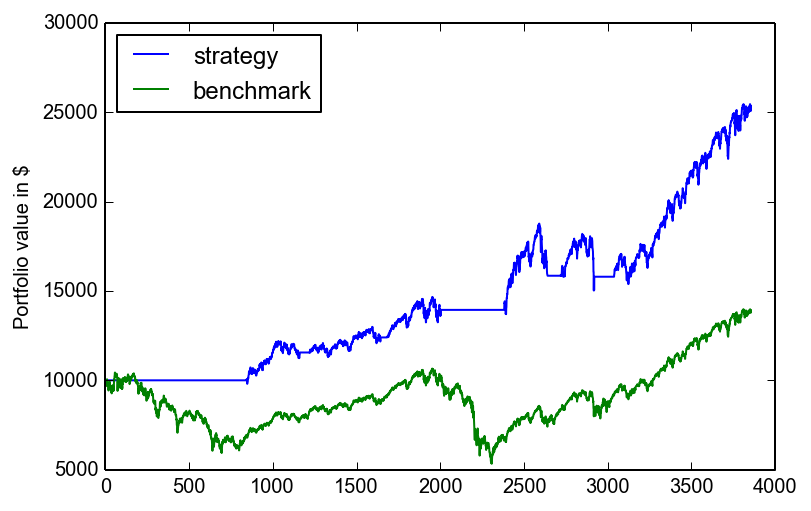

In [22]:
pf.plot_equity_curve(dbal, benchmark=benchmark.dbal)

Plot Trades

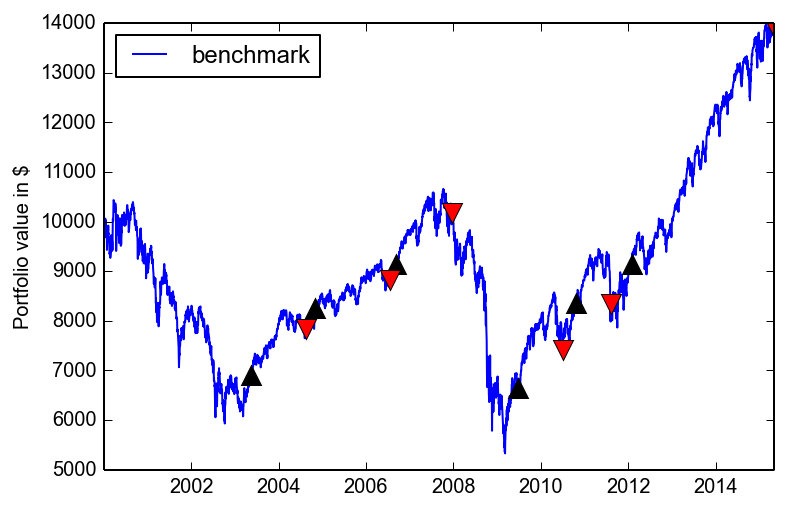

In [23]:
pf.plot_trades(dbal, benchmark=benchmark.dbal)

Bar Graph: Strategy vs Benchmark

,strategy,benchmark
annual_return_rate,6.26,2.18
max_closed_out_drawdown,-19.96,-50.02
drawdown_annualized_return,-3.19,-22.93
drawdown_recovery,-1.29,-1.42
best_month,14.38,17.90
worst_month,-14.75,-24.09
sharpe_ratio,0.64,0.21
sortino_ratio,0.66,0.28
monthly_std,2.51,3.99


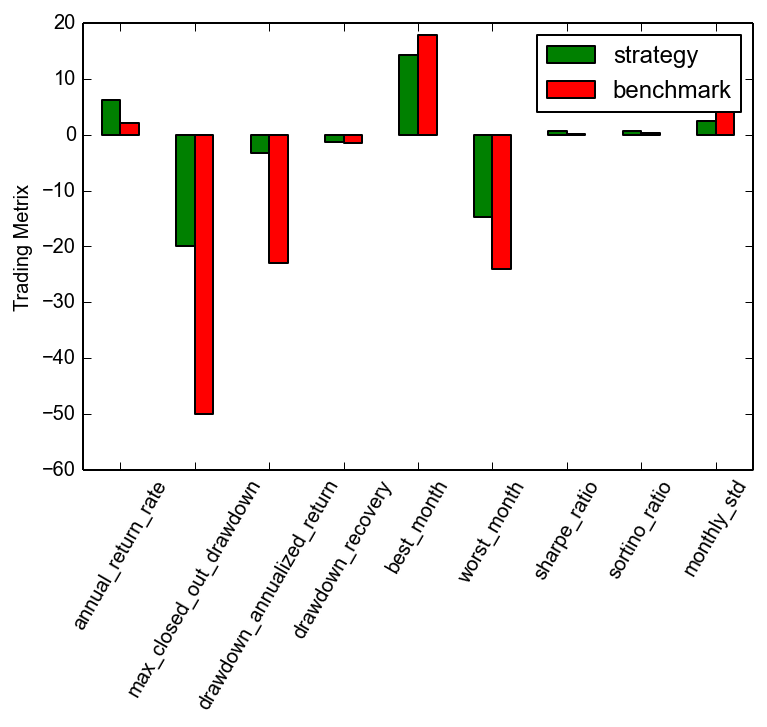

In [24]:
metrics = ('annual_return_rate',
           'max_closed_out_drawdown',
           'drawdown_annualized_return',
           'drawdown_recovery',
           'best_month',
           'worst_month',
           'sharpe_ratio',
           'sortino_ratio',
           'monthly_std')
df = pf.plot_bar_graph(stats, benchmark.stats, *metrics)
df